<a href="https://colab.research.google.com/github/Zokoban/pyOCRTEN/blob/Full_TensorFlow/ocr_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

To Do List :

Modeling:
*   Test other neural network structure (LSTM cell)
*   Change the neural network to line prediction instead of word prediction

Pre_processing:
*   Focus on the bad result and find some improvement solution :
>1.   Use image_generation
>2.   Implement Caracter Error Rate (CER)
>3.   Check the symbols/characters which have the lowest prediction result and find solution (For example: generate more image related to these symbols)

Model post_processing:
*	Work on the "greedy decoder" to improve the prediction choice at the end

End result processing:
*	Work on the Prediction end result to improve it through a new model such as:
>1.	Orthographic model (done)
>2.	NLP model

General:
*	Improve the general aesthetic:
>1.	Create pretty diagram
>2.	Add more comments
>3.	Add more "text" cell for explanation
>4.	Improve the aesthetic of the titles, etc...

Model application next steps:
*	Create our own segmentation method to directly perform prediction on the form image instead of using the images provided by the dataset. (ongoing)


## Download all data on the drive 

In [1]:
!wget -q https://git.io/J0fjL -O IAM_Words.zip
!unzip -qq IAM_Words.zip
!
!mkdir data
!mkdir data/words
!tar -xf IAM_Words/words.tgz -C data/words
!mv IAM_Words/words.txt data

## Load all the required packages

In [2]:
import pandas as pd
import numpy as np
import csv
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

# Data Preparation

## Load word.txt file

In [6]:
#############
# Variables #
#############

path_to_txt = "data/words.txt"

#--------------------------------------

#########################
# Function get_word_txt #
#########################

def get_word_txt(path_to_txt):
  word_txt=pd.read_csv(path_to_txt, 
                      sep=' ', 
                      names=["word_id","segmentation_result","gray_level","x","y","pxw","pxh","grammatical_tag","transcription_1","transcription_2","transcription_3"], 
                      quoting=csv.QUOTE_NONE, 
                      skiprows=18, 
                      on_bad_lines="warn")

  def f(x):
      if x == "nan":
          return ""
      else:
          return x
  word_txt["transcription"]=word_txt.transcription_1.astype("str")+\
                            word_txt.transcription_2.astype("str").apply(f)+\
                            word_txt.transcription_3.astype("str").apply(f)
  word_txt=word_txt.drop(columns=["transcription_1","transcription_2","transcription_3"])

  def f(x):
      return len(x)

  word_txt["number_components"]=word_txt.transcription.apply(f)

  

  return word_txt

#----------------------------------------------------------

word_txt = get_word_txt(path_to_txt)

print("word_txt Length: ",len(word_txt))
word_txt.head()

word_txt Length:  115320


,word_id,segmentation_result,gray_level,x,y,pxw,pxh,grammatical_tag,transcription,number_components
0,a01-000u-00-00,ok,154,408,768,27,51,AT,A,1
1,a01-000u-00-01,ok,154,507,766,213,48,NN,MOVE,4
2,a01-000u-00-02,ok,154,796,764,70,50,TO,to,2
3,a01-000u-00-03,ok,154,919,757,166,78,VB,stop,4
4,a01-000u-00-04,ok,154,1185,754,126,61,NPT,Mr.,3


### Choice of the fraction of the dataset.
### Removal of the transcription error.
### Removal of the unwanted columns.

In [10]:
#############
# Variables #
#############

fraction = 0.5
data_dir = "data/words/"
image_extensions = [".png"]  # add there all your images file extensions
img_type_accepted_by_tf = ["png"]

#--------------------------------------------------------------------------
from pathlib import Path
import imghdr

def img_path(word):
    path=data_dir+word.split("-")[0]+"/"+word.split("-")[0]+"-"+word.split("-")[1]+"/"+word+".png"
    
    return path

def removal_of_corrupt_image(df):
  index_to_drop=[]
  for filepath in Path(data_dir).rglob("*"):
      if filepath.suffix.lower() in image_extensions:
          img_type = imghdr.what(filepath)
          if img_type is None:
              index_to_drop.append(df[df.filepath==str(filepath)].index)
              df=df.drop(labels=df[df.filepath==str(filepath)].index)
              print(f"{filepath} is not an image")
          elif img_type not in img_type_accepted_by_tf:
              df=df.drop(labels=df[df.filepath==str(filepath)].index)
              print(f"{filepath} is a {img_type}, not accepted by TensorFlow and is drop")
  return df

def word_txt_cleaning(word_txt,fraction,random_state=None):

  if random_state==None:
    random_state=np.random.randint(10000)

  list_columns_to_remove=["segmentation_result","gray_level","x","y","pxw","pxh","grammatical_tag","number_components"]

  df = word_txt[word_txt.segmentation_result == "ok"]\
      .drop(columns=list_columns_to_remove)\
      .sample(frac=fraction,random_state=random_state)

  df["filepath"]=df.word_id.apply(img_path)
  df=removal_of_corrupt_image(df)

  return df

#------------------------------------------------------------------

##################################
#   Removal of unwanted Column   #
#   And removal of corrupt image #
##################################


df = word_txt_cleaning(word_txt,fraction)

df.head()

data/words/a01/a01-117/a01-117-05-02.png is not an image
data/words/r06/r06-022/r06-022-03-05.png is not an image


,word_id,transcription,filepath
109104,p03-112-03-07,a,data/words/p03/p03-112/p03-112-03-07.png
74144,h04-061-08-04,households,data/words/h04/h04-061/h04-061-08-04.png
23449,c02-049-01-02,with,data/words/c02/c02-049/c02-049-01-02.png
10145,a04-085-09-01,by,data/words/a04/a04-085/a04-085-09-01.png
35996,d05-030-04-10,his,data/words/d05/d05-030/d05-030-04-10.png


## Separation of dataset and Loading + Preprocessing of the image

###Loading and preprocessing functions

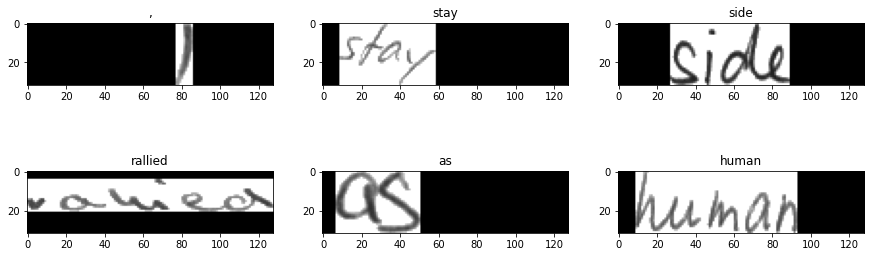

In [14]:
#############
# Variables #
#############

batch_size = 64
image_width=128
image_height=32
imgSize = (image_height, image_width)

random_state=np.random.randint(10000)
train_size=0.8
validation_size=0.5
#-----------------------------------

###############################################################
# Definition of functions:                                    #
#     - Loading images                                        #
#     - Preprocessing of images (resizing without distortion) #
###############################################################

import tensorflow as tf
from sklearn.model_selection import train_test_split
import numpy as np

#Loading function of images (with tensorflow)
@tf.function
def load_image(filepath):
    im = tf.io.read_file(filepath)
    im = tf.image.decode_png(im, channels=0)

    return im

#Preprocessing function of images (with tensorflow)
@tf.function
def preprocess(filepath, imgSize=(32, 128), dataAugmentation=False, scale=0.8, isthreshold=False):



    img = load_image(filepath)/255
    # there are damaged files in IAM dataset - just use black image instead
    if img is None:
        img = tf.ones([imgSize[0], imgSize[1], 1])
        print("None")

    if dataAugmentation:
        stretch = scale*(tf.random.uniform([1], 0, 1)[0] - 0.3) # -0.5 .. +0.5
        wStretched = tf.maximum(int(float(tf.shape(img)[0]) * (1 + stretch)), 1) # random width, but at least 1
        img = tf.image.resize(img, (wStretched, tf.shape(img)[1])) # stretch horizontally by factor 0.5 .. 1.5

    (wt, ht) = imgSize

    w, h = float(tf.shape(img)[0]), float(tf.shape(img)[1])

    fx = w / wt
    fy = h / ht

    f = tf.maximum(fx, fy)

    newSize = (tf.maximum(tf.minimum(wt, int(w / f)), 1), tf.maximum(tf.minimum(ht, int(h / f)), 1)) # scale according to f (result at least 1 and at most wt or ht)

    img = tf.image.resize(img, newSize)


    dx = wt - newSize[0]
    dy = ht - newSize[1]

    if dataAugmentation :
        dx1=0
        dy1=0
        if dx!=0:
            dx1 = tf.random.uniform([1], 0, dx, tf.int32)[0]
        if dy!=0:
            dy1 = tf.random.uniform([1], 0, dy, tf.int32)[0]
        img = tf.pad(img[..., 0], [[dx1, dx-dx1], [dy1, dy-dy1]], constant_values=0)
    else :
        img = tf.pad(img[..., 0], [[0, dx], [0, dy]], constant_values=0)

    if isthreshold:
        return tf.expand_dims(1-(1-img)*tf.cast(img < 0.8, tf.float32), -1)
    return tf.expand_dims(img, -1)

def create_dataset(X_path,y_label,batch_size):
  dataset = tf.data.Dataset.from_tensor_slices((X_path, y_label))
  dataset = dataset.shuffle(10000)\
                  .map(lambda x, y : [preprocess(x, imgSize, dataAugmentation=True, scale=0.8, isthreshold=True), y])\
                  .batch(batch_size, drop_remainder=True)
  return dataset
#-----------------------------------------------------------------------------

#########################################
# Creation of the train & test datasets #
#########################################

#Split of dataframes 
X_train_path, X_path_temp, y_train, y_temp = train_test_split(df.filepath.values, df.transcription.values, train_size=train_size, random_state=random_state)
X_test_path, X_val_path, y_test, y_val = train_test_split(X_path_temp, y_temp, train_size=validation_size, random_state=random_state)

# Creation of dataset_train and dataset_test tensor and preprocessing of images
dataset_train = create_dataset(X_train_path,y_train,batch_size)
dataset_test = create_dataset(X_test_path,y_test,batch_size)
dataset_validation = create_dataset(X_val_path,y_val,batch_size)

#-----------------------------------------------------------------------------

################################################
# Iteration on dataset_train                   #
# Display of several images from train dataset #
################################################

X_t, y_t = next(iter(dataset_train))

def display_image_from_tf_dataset(X_t,y_t):
  plt.figure(figsize=(15,5))
  for j, i in enumerate(np.random.randint(low=0, high=len(X_t), size=[6])):
      plt.subplot(2,3,j+1)
      plt.imshow(X_t[i][...,0], cmap='gray')
      plt.title(y_t[i].numpy().decode('utf'))

display_image_from_tf_dataset(X_t,y_t)

## Vectorization of the labels

In [15]:
#############
# Variables #
#############

import string
#charList = list(string.ascii_lowercase)
#charList = list('!\'.?abcdefghijklmnopqrstuvwxyz')
charList = list(' !"#$%&\'()*+,-./0123456789:;<=>?@ABCDEFGHIJKLMNOPQRSTUVWXYZ[\\]^_`abcdefghijklmnopqrstuvwxyz{|}~')
#------------------------------------------------

def encode_labels(labels):
    table = tf.lookup.StaticHashTable(
        tf.lookup.KeyValueTensorInitializer(charList, np.arange(len(charList)), value_dtype=tf.int32),
        default_value = 0,
        name='chard2id')
    return table.lookup(tf.compat.v1.string_split(labels, sep=''))


#--------------------------------------------------------------------

#######################################
# Encoding of the train & test labels #
#######################################

# Encoding of y_train
dataset_train = dataset_train.map(lambda X,y : [X, encode_labels(y)])

# Encode of y_test
dataset_validation = dataset_validation.map(lambda X,y : [X, encode_labels(y)])

#--------------------------------------------------------------------

##############################
# Display of label encoding  #
##############################

a = encode_labels(y_train[:10])

print(y_train[:10])
print(tf.sparse.to_dense(a).numpy(),":\n")

x=15
a = encode_labels(y_test[x:x+10])

print("\n-------------------------------------------\n\n",y_test[x:x+10],":\n")

print(tf.sparse.to_dense(a).numpy())

#------------------------------------------------------------------

['stone' 'are' 'was' 'from' 'straight' 'a' '.' 'event' 'presence'
 'plastic']
[[83 84 79 78 69  0  0  0]
 [65 82 69  0  0  0  0  0]
 [87 65 83  0  0  0  0  0]
 [70 82 79 77  0  0  0  0]
 [83 84 82 65 73 71 72 84]
 [65  0  0  0  0  0  0  0]
 [14  0  0  0  0  0  0  0]
 [69 86 69 78 84  0  0  0]
 [80 82 69 83 69 78 67 69]
 [80 76 65 83 84 73 67  0]] :


-------------------------------------------

 ['separated' '"' 'it' 'man' ',' 'shape' 'among' 'public' 'frequent'
 'letter'] :

[[83 69 80 65 82 65 84 69 68]
 [ 2  0  0  0  0  0  0  0  0]
 [73 84  0  0  0  0  0  0  0]
 [77 65 78  0  0  0  0  0  0]
 [12  0  0  0  0  0  0  0  0]
 [83 72 65 80 69  0  0  0  0]
 [65 77 79 78 71  0  0  0  0]
 [80 85 66 76 73 67  0  0  0]
 [70 82 69 81 85 69 78 84  0]
 [76 69 84 84 69 82  0  0  0]]


#Model Creation

##Modelisation

In [19]:
#@title Load weight model function (boolean, model, name_model)

def load_weight_model(load_model,model,name):
  history=None
  #------------------------------
  if load_model: #Load model weights
    drive.mount("/drive",force_remount=True)
    try:
      model.load_weights("/drive/MyDrive/DataScience/OCR/Models/"+name)
      print("Model weights loaded !")
    except:
      print("Model name does not exist, Model weights not loaded !")
    #----------------------------
    try: #Load history
      with open("/drive/MyDrive/DataScience/OCR/Models/"+name+"training_history", "rb") as file_pi:
        history = pickle.load(file_pi)
        print("History loaded !")
    except:
      print("History not loaded !")

  #--------------------------------
  else:
    print("Model weights not loaded !")

  return model,history

In [17]:
#@title Model_CRNN_GRU
#############
# Variables #
#############

#X_t.shape[1:]

#-------------------------------------------------------------------------
from google.colab import drive
#########################################################
# Definition of a model CRNN taken on DataScienTest OCR #
#                           model_CRNN_GRU              #
#########################################################

import tensorflow as tf
from tensorflow.keras.layers import Conv2D, BatchNormalization, MaxPooling2D, LeakyReLU, Dropout
from tensorflow.keras.layers import GRU, Bidirectional, Dense, Lambda


def build_model_CRNN_GRU(load_model_var, name_load_model,numHidden,image_shape):
  #Create_model_CRNN
    model = tf.keras.Sequential()

    # Layer 1
    model.add(Conv2D(filters=32, kernel_size=(5,5), padding='SAME', input_shape = image_shape))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

    # Layer 2
    model.add(Conv2D(filters=64, kernel_size=(5,5), padding='SAME'))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

    # Layer 3
    model.add(Conv2D(filters=128, kernel_size=(3,3), padding='SAME'))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    model.add(MaxPooling2D(pool_size=(2,1), strides=(2,1)))

    # Layer 4
    model.add(Conv2D(filters=128, kernel_size=(3,3), padding='SAME'))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    model.add(MaxPooling2D(pool_size=(2,1), strides=(2,1)))

    # Layer 5
    model.add(Conv2D(filters=256, kernel_size=(3,3), padding='SAME'))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    model.add(MaxPooling2D(pool_size=(2,1), strides=(2,1)))
    model.add(Dropout(0.4))


    model.add(Lambda(lambda x :tf.squeeze(x, axis=1)))

    # Bidirectionnal RNN
    model.add(Bidirectional(GRU(numHidden, return_sequences=True)))
    # Classification of characters
    model.add(Dense(len(charList)+1))
    
    model,training_history=load_weight_model(load_model_var,model,name_load_model)

    return model, training_history

#---------------------------------------------------------------------------


In [21]:
#@title Building of models
#############
# Variables #
#############
numHidden = 256

image_width=128
image_height=32

image_shape=[image_height,image_width,1]

load_model_var_CNN = True
name_load_model_CNN = "CRNN_1_2710"

############################
# Building the model CRNN  #
#         model_3          #
############################

print("Loading of Model:",name_load_model_CNN)

model_CRNN_GRU, training_history = build_model_CRNN_GRU(load_model_var_CNN, name_load_model_CNN, numHidden, image_shape)


#model_CRNN_GRU.summary()
#

#--------------------------------------------------------------------------

Loading of Model: CRNN_1_2710
Mounted at /drive
Model weights loaded !
History not loaded !


##Compilation and creation of loss function

###Model_CRNN

In [ ]:
#############
# Variables #
#############

model_compiled = model_CRNN_GRU

#---------------------------------------

#########################################
# Definition of a loss function for CTC #
#########################################

#Loss function for CTC
def loss(labels, logits):
    return tf.reduce_mean(tf.nn.ctc_loss(
        labels = labels,
        logits = logits,
        logit_length = [logits.shape[1]]*logits.shape[0],
        label_length = None,
        logits_time_major = False,
        blank_index=-1))

#----------------------------------------------------------

######################################################
# Compilation of model_3 with Adam and Loss function #
######################################################
from tensorflow.keras.optimizers import Adam

model_compiled.compile(optimizer=Adam(1e-3),loss=loss)

#------------------------------------------------------------

#Training

###Model_CRNN

In [ ]:
#############
# Variables #
#############

save_model_var=False
epochs = 20
name_model = "CRNN_2_2410"
model_trained = model_CRNN_GRU

#---------------------------------------------------
from google.colab import drive
import pickle
#########################
# Training of the model #
#########################

#Training of model 3
training_history=model_trained.fit(dataset_train,epochs=epochs, validation_data=dataset_validation)

#---------------------------------------------------------
#########################
# Saving of the model   #
#########################

def save_model(save_model,model,name,training_hist=None):
  drive.mount("/drive",force_remount=True)
  if save_model:
    model.save_weights("/drive/MyDrive/DataScience/OCR/Models/"+name)
    print("Model saved !")
    if training_hist != None:
      with open("/drive/MyDrive/DataScience/OCR/Models/"+name+"_training_history", 'wb') as file_pi:
        pickle.dump(training_history.history, file_pi)
        print("History saved !")
  else:
    print("Model not saved !")

save_model(save_model_var, model_trained,name_model,training_history)

Epoch 1/20
678/678 [==============================] - 56s 79ms/step - loss: 12.0165 - val_loss: 15.6506
Epoch 2/20
678/678 [==============================] - 49s 72ms/step - loss: 6.4024 - val_loss: 6.6618
Epoch 3/20
678/678 [==============================] - 50s 73ms/step - loss: 4.1486 - val_loss: 3.5105
Epoch 4/20
678/678 [==============================] - 49s 72ms/step - loss: 3.3695 - val_loss: 3.0873
Epoch 5/20
678/678 [==============================] - 50s 74ms/step - loss: 2.8958 - val_loss: 3.1933
Epoch 6/20
678/678 [==============================] - 53s 77ms/step - loss: 2.6298 - val_loss: 2.8064
Epoch 7/20
678/678 [==============================] - 49s 73ms/step - loss: 2.3880 - val_loss: 2.8780
Epoch 8/20
678/678 [==============================] - 50s 73ms/step - loss: 2.2437 - val_loss: 2.3025
Epoch 9/20
678/678 [==============================] - 50s 73ms/step - loss: 2.0981 - val_loss: 2.5998
Epoch 10/20
678/678 [==============================] - 50s 73ms/step - loss: 1.9

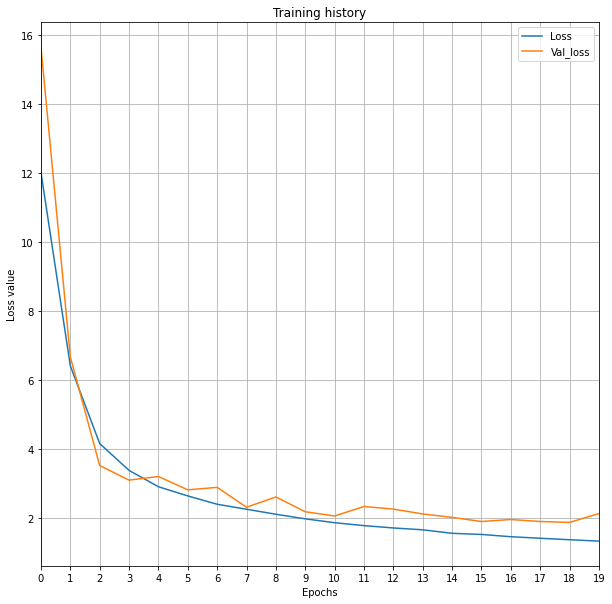

In [ ]:
#############
# Variables #
#############

history= training_history.history

#-------------------------------------
################################
# Display of Training history  #
################################

plt.figure(figsize=(10,10))

plt.plot(history["loss"],label="Loss")
plt.plot(history["val_loss"],label="Val_loss")

plt.legend()
plt.xticks(np.arange(0,20,1));

plt.xlim([0,19]);
plt.grid()
plt.xlabel("Epochs")
plt.ylabel("Loss value");
plt.title("Training history");

#Prediction & Evaluation

## Predictions

In [ ]:
#@title GreedyDecoder, Prediction, Orthographique Correction functions

from textblob import TextBlob

#####################################################
# Definition of decode function and Greedy decoder  #
#####################################################

def decode_codes(codes):
    table = tf.lookup.StaticHashTable(
        tf.lookup.KeyValueTensorInitializer(
            np.arange(len(charList)),
            charList,
            key_dtype=tf.int32
        ),
        '',
        name='id2char'
    )
    return table.lookup(codes)

def greedy_decoder(logits):
    # ctc beam search decoder
    predicted_codes, _ = tf.nn.ctc_greedy_decoder(
        # shape of tensor [max_time x batch_size x num_classes]
        tf.transpose(logits, (1, 0, 2)),
        [logits.shape[1]]*logits.shape[0]
    )

    # convert to int32
    codes = tf.cast(predicted_codes[0], tf.int32)

    # Decode the index of caracter
    text = decode_codes(codes)

    # Convert a SparseTensor to string
    text = tf.sparse.to_dense(text).numpy().astype(str)

    return list(map(lambda x: ''.join(x), text))

#--------------------------------------------------------

#################################################
# Function: Prediction and Decoding of dataset  #
#################################################

def predictions_decode(dataset,model):
  y_pred=[]
  y_true=[]
  for X_t,y_t in dataset:
    y_pred.append(greedy_decoder(model(X_t)))
    y_true.append(y_t)


  results=list(zip(np.array(y_true).flatten(),np.array(y_pred).flatten(),))
  return y_true,y_pred,results

#---------------------------------------------------------------

###################################
# Function: Prediction correction #
###################################

def correct_word(x):
  return TextBlob(x).correct()

def correct_prediction(y_true,y_pred):

  y_pred_corr = map(correct_word,np.array(y_pred).flatten())
  results_corrected=list(zip(np.array(y_true).flatten(),y_pred_corr,))

  return y_pred_corr, results_corrected



In [ ]:
#############
# Variables #
#############

model = model_compiled
dataset_test = dataset_test

#--------------------------------------------------------
######################################################
# Decoded predictions and Orthographique corrections #
######################################################

y_true,y_pred, results = predictions_decode(dataset_test,model)

y_pred_corr , results_corrected = correct_prediction(y_true,y_pred)



##Evaluation

In [ ]:
#@title Word accuracy function
##########################
# Function Word accuracy #
##########################
import difflib

def word_accuracy(results,verbose,name_results=None):

  score=[]
  for words in results: # Calculation of the percentage of letters accuracy for each word between transcription and prediction
    score.append(difflib.SequenceMatcher(None,words[0].decode("utf-8"),words[1]).ratio())
  
  if verbose:
    print("The average accuracy for our words prediction,",name_results,", is: ",np.mean(score),
      "\n\n--------------------------------------------------------------------\n")
    
  return score

#----------------------------------------

The average accuracy for our words prediction, raw , is:  0.9301559359315136 

--------------------------------------------------------------------

The average accuracy for our words prediction, with autocorrect , is:  0.923466293340604 

--------------------------------------------------------------------



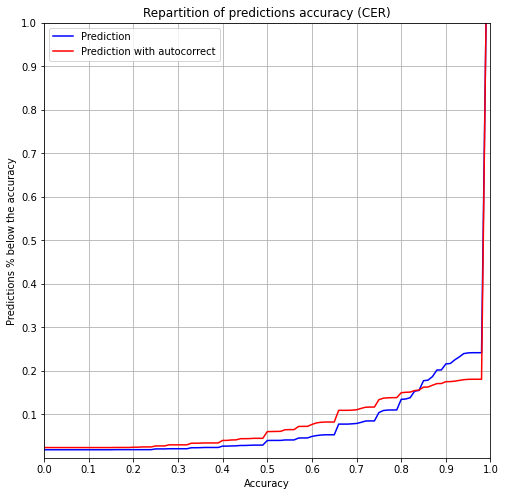

According to the graph we have for the basic predictions approximatly:
 - 2.0 % predictions at <10% of accuracy
 - 2.0 % predictions between 10% - 50% of accuracy
 - 20.0 % predictions between 50%- 99% of accuracy
 - 76.0 % predictions at 100% of accuracy


According to the graph we have for the autocorrect predictions approximatly:
 - 2.0 % predictions at <10% of accuracy
 - 4.0 % predictions between 10% - 50% of accuracy
 - 12.0 % predictions between 50%- 99% of accuracy
 - 82.0 % predictions at 100% of accuracy


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


In [ ]:
#@title Display of the prediction accuracy
#############
# Variables #
#############

results = results
results_corrected = results_corrected

results_name = "raw"
results_corrected_name = "with autocorrect"

verbose = True

#-----------------------------------------------------------------------------------------------------------------------------

####################################
# Evaluation of the words accuracy #
####################################

score = word_accuracy(results, verbose, results_name)
score_corrected = word_accuracy(results_corrected,verbose, results_corrected_name)

#-----------------------------------------------------

##################################################
# Display of the word accuracy (CER) repartition #
##################################################

plt.figure(figsize=(8,8))
# evaluation of the histogram
values, base = np.histogram(score, bins=100)
values_corrected, base_corrected = np.histogram(score_corrected, bins=100)
#evaluation the cumulative
cumulative = np.cumsum(values)
cumulative_corrected = np.cumsum(values_corrected)
# plot the cumulative function
plt.plot(base[:-1], cumulative/cumulative[-1], c='blue',label="Prediction")
plt.plot(base[:-1], cumulative_corrected/cumulative_corrected[-1], c='red',label="Prediction with autocorrect")


plt.title("Repartition of predictions accuracy (CER)")
plt.xlabel("Accuracy")
plt.ylabel("Predictions % below the accuracy")
plt.xticks(np.arange(0,1.1,0.1))
plt.yticks(np.arange(0.1,1.1,0.1))
plt.xlim([0,1])
plt.ylim([0,1])
plt.grid()
plt.legend(loc="upper left")
plt.show();

ar_res = np.array(results)
ar_score = np.array(score)

ar_res_cor = np.array(results_corrected)
ar_score_cor = np.array(score_corrected)

print("According to the graph we have for the basic predictions approximatly:\n",
      "-",np.round((len(ar_res[(ar_score <= 0.1)])/len(ar_res))*100), "% predictions at <10% of accuracy\n",
      "-",np.round((len(ar_res[(0.1 < ar_score) & (ar_score <= 0.5)])/len(ar_res))*100)  ,"% predictions between 10% - 50% of accuracy\n",
      "-",np.round((len(ar_res[(0.5 < ar_score) & (ar_score <= 0.99)])/len(ar_res))*100) ,"% predictions between 50%- 99% of accuracy\n",
      "-",np.round((len(ar_res[(0.99 < ar_score)])/len(ar_res))*100) ,"% predictions at 100% of accuracy")

print("\n\nAccording to the graph we have for the autocorrect predictions approximatly:\n",
      "-",np.round((len(ar_res_cor[(ar_score_cor <= 0.1)])/len(ar_res_cor))*100), "% predictions at <10% of accuracy\n",
      "-",np.round((len(ar_res_cor[(0.1 < ar_score_cor) & (ar_score_cor <= 0.5)])/len(ar_res_cor))*100)  ,"% predictions between 10% - 50% of accuracy\n",
      "-",np.round((len(ar_res_cor[(0.5 < ar_score_cor) & (ar_score_cor <= 0.99)])/len(ar_res_cor))*100) ,"% predictions between 50%- 99% of accuracy\n",
      "-",np.round((len(ar_res_cor[(0.99 < ar_score_cor)])/len(ar_res_cor))*100) ,"% predictions at 100% of accuracy");

In [ ]:
#@title Display of several failed predictions
#############
# Variables #
#############

results = results
score = score
#-------------------------------------------

########################################
# Display of several failed prediction #
########################################

np.array(results)[np.array(score) < 0.1][:10]

#-------------------------------------------

array([["'", '.'],
       ["'", ','],
       ["'", ','],
       ['is', 'to'],
       ['.', '"'],
       ['I', ','],
       ["'", ','],
       [',', '.'],
       ['I', ','],
       ["'", '.']], dtype='<U17')

# Reading of one form using a model

In [ ]:
#############
# Variables #
#############

form_id ="a01-020u"

#--------------------------------------------------------------------------
from pathlib import Path
import imghdr

##################################
#   Removal of unwanted Column   #
##################################

list_columns_to_remove=["segmentation_result","gray_level","x","y","pxw","pxh","grammatical_tag","number_components"]

form_df = word_txt[word_txt.segmentation_result == "ok"]\
          .drop(columns=list_columns_to_remove)

################################
# Selection of wanted form     #
################################

form_df = form_df[form_df.word_id.str.contains(form_id)]

#----------------------------------------------------

###############################
#    Removal of corrupt image #
###############################

print("df Length: ",len(form_df))
form_df["filepath"]=form_df.word_id.apply(img_path)
form_df=removal_of_corrupt_image(form_df)
print("df Length: ",len(form_df))

df Length:  68
data/words/r06/r06-022/r06-022-03-05.png is not an image
data/words/a01/a01-117/a01-117-05-02.png is not an image
df Length:  68


In [ ]:
#############
# Variables #
#############

model = model_CRNN_GRU
batch_size = 1
image_width=128
image_height=32
imgSize = (image_height, image_width)

#-----------------------------------

#########################################
# Creation of the train & test datasets #
#########################################

# Creation of dataset_train tensor and preprocessing of images
data_form = tf.data.Dataset.from_tensor_slices((form_df.filepath.values, form_df.transcription.values))
data_form = data_form\
                .map(lambda x, y : [preprocess(x, imgSize, dataAugmentation=True, scale=0.8, isthreshold=True), y])\
                .batch(batch_size, drop_remainder=True)

#-----------------------------------------------------------------------------

##############################
# Prediction using the model #
##############################

y_pred=[]
y_true=[]
for X_t,y_t in data_form:
  y_pred.append(greedy_decoder(model(X_t)))
  y_true.append(y_t.numpy()[0].decode("utf-8"))

results=list(zip(np.array(y_true).flatten(),np.array(y_pred).flatten(),))


y_pred=np.array(y_pred).flatten()
y_true=np.array(y_true).flatten()

pred_text=' '.join(y_pred)
true_text=' '.join(y_true)

print("\nTrue text:\n")
print(true_text)
print("\nPredicted text:\n")
print(pred_text)
print("\nCorrected predicted text:\n")
print(correct_word(pred_text))



True text:

Mr. Macleod went on with the conference at Lancaster House despite the crisis which had blown up . He has now revealed his full plans to the Africans and Liberals attending . These plans do not give the Africans the overall majority they are seeking . African delegates are studying them today . The conference will meet to discuss the function of a proposed House of Chiefs .

Predicted text:

MR. Maclead went an with the conference at Lancaster House despite the arisis which had blown up . He has now revealed his full plans to the Africans and likeats attending . These olcuss do not give the Africans the overall mgjority they are seeking . African delegates oe studying them tody . The conference will meer to discuss the function of a puoposed House of Chiefs .

Corrected predicted text:

of. Maclead went an with the conference at Lancaster House despite the crisis which had blown up . He has now revealed his full plans to the Africans and likes attending . These occurs do n

# Segmentation of a Form to a list of words

## Creation of the list of word images

In [ ]:
#@title Mounting the drive (having the form images) and listing of the paths
from google.colab import drive
import tarfile
import os

formsAD_path = "./formsA-D/"

drive.mount("/drive")
list_tar=["lines","formsA-D"]
for name in list_tar:
  my_tar = tarfile.open("/drive/MyDrive/DataScience/OCR/"+name+".tgz")
  my_tar.extractall('./'+name) # specify which folder to extract to

my_tar.close()

dir_list=os.listdir(formsAD_path)
dir_list = list(map(lambda x :formsAD_path+x,dir_list))

Drive already mounted at /drive; to attempt to forcibly remount, call drive.mount("/drive", force_remount=True).


In [ ]:
#@title Functions to cut lines from form
import numpy as np
#img = np.sum(cv2.imread(formid),axis=2)[690:2700]
def black_white_img(formid):
  img = cv2.imread(formid)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)#[690:2700]

  (thresh, blackAndWhiteImage) = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY)
  return blackAndWhiteImage

def get_line_cut(img):
  img_col = np.sum(img,axis=1)
  list_lines= []

  for i, value in enumerate(img_col):
    if value > img_col.mean():
      list_lines.append(i)
  #list_lines.append(1e10)

  new_list_lines=[]
  temporary_list=[]
  last_line=list_lines[0]
  for line in list_lines:
    if line <= last_line+15:
      
      temporary_list.append(line)
      last_line = line
    
    else:
      
      new_list_lines.append(int(np.mean(temporary_list)))
      temporary_list=[line]
      last_line = line

  temp_list=[]
  for i in range(len(new_list_lines)-1):
    temp_list.append(new_list_lines[i+1]-new_list_lines[i])

  new_list_lines.append(new_list_lines[-1]+int(np.mean(temp_list)))
  return new_list_lines

def get_lines(img):
  max_line=[]
  for line in (img==0):
    compteur_list=[]
    compteur=0
    
    for col in line:
      
      if col == True:
        compteur = compteur+1
      else:
        compteur_list.append(compteur)
        compteur=0

    compteur_list.append(compteur)
    
    max_line.append(np.max(compteur_list))
  max_line=np.array(max_line)

  return max_line

Text(0.5, 1.0, './formsA-D/c02-026.png')

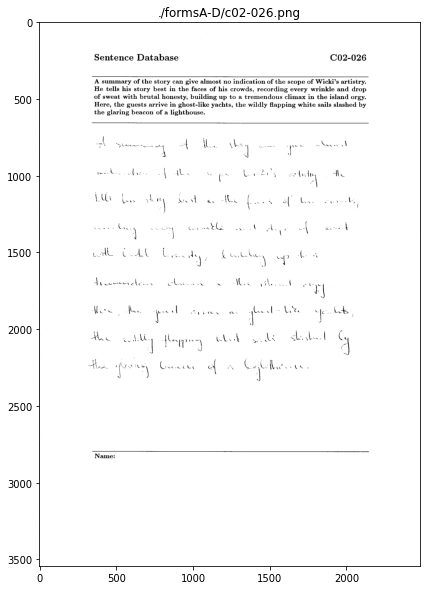

In [ ]:
#@title Random selection and display of the formID
formid = dir_list[np.random.randint(0,len(dir_list))]
img_color=cv2.imread(formid)
img_bw=black_white_img(formid)

list_lines=get_line_cut(img_bw)

plt.figure(figsize=(10,10))

plt.imshow(img_bw,cmap="gray")
plt.title(formid)


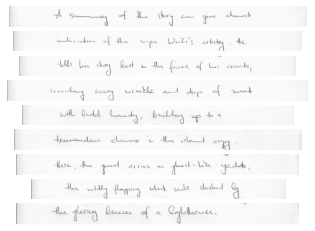

In [ ]:
#@title Creation and display of the list of lines from the form
max_line=get_lines(img_bw)
max_line=max_line>max_line.max()/2
x_bot=np.argsort(max_line[2000:])[-1]+2000-10
x_top=np.argsort(max_line[500:1000])[-1]+500+10

only_text_img_color = img_color[x_top:x_bot,:,:]
only_text_img_bw = img_bw[x_top:x_bot,:]

lines=get_line_cut(only_text_img_bw)

list_img_lines=[]
for i in range(len(lines)-1):
  list_img_lines.append(only_text_img_color[lines[i]:lines[i+1],:,:])

for j in range(len(list_img_lines)):
  plt.subplot(len(list_img_lines),1,j+1)
  plt.axis('off')
  plt.imshow(list_img_lines[j],cmap="gray")

In [ ]:
#@title Functions for word cutting
import cv2
import numpy as np

def image_contour(img):
    src_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    src_gray = cv2.blur(src_gray, (3,3))
    threshold=100
    canny_output = cv2.Canny(src_gray, threshold, threshold * 2)
    
    return src_gray,cv2.findContours(canny_output, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)

    
def image_with_contours(img,contours=None):
    if contours==None:
        img, (contours,hierarchy) = image_contour(img)
    
    else:
        img = img[...,-1].astype(np.uint8)*255

    image_copy = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    plt.figure(figsize=(10,15))
    return cv2.drawContours(image=image_copy, 
                                contours=contours, 
                                contourIdx=-1, 
                                color=(0, 255, 0), 
                                thickness=4, 
                                lineType=cv2.LINE_AA);

def display_contour_box(img,contours=None):
    
    if contours==None:
      image_copy,(contours,hierarchy) = image_contour(img)
    
    else:
      src_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
      image_copy = cv2.blur(src_gray, (3,3))

    for c in contours:
        x, y, w, h = cv2.boundingRect(c)
        cv2.rectangle(image_copy, (x, y), (x + w, y + h), (36,255,12), 2)

    plt.figure(figsize=(20,30))
    plt.imshow(image_copy.astype(int))
    plt.xticks([])
    plt.yticks([]);


def create_new_contours(contours,xmax,ymax):
  list_of_exempt=[]
  new_contours=[]
  for i,c1 in enumerate(contours):
    if i in list_of_exempt:
      
      pass
    
    else:
      list_of_exempt.append(i)
      for j,c2 in enumerate(contours):
        if j in list_of_exempt:
          pass
        
        else:
          rec1=cv2.boundingRect(c1)
          rec2=cv2.boundingRect(c2)
          ctot=np.vstack([c1,c2])
          rectot=cv2.boundingRect(ctot)

          rec1=np.array(rec1)
          rec2=np.array(rec2)
          rectot=np.array(rectot)

          y_dist=rectot[3]-(rec1[3]+rec2[3])
          x_dist=rectot[2]-(rec1[2]+rec2[2])
          y_start_dist=np.abs(rec1[1]-rec2[1])

          if y_dist < ymax and x_dist<xmax:
            
            c1=ctot
            list_of_exempt.append(j)

       
      new_contours.append(c1)

  return new_contours

def contours_sorting(contours):
  list_x=[]
  for i,c in enumerate(contours):
    x, y, w, h = cv2.boundingRect(c)
    list_x.append([i,x])
  list_x= np.array(list_x)
  list_x=list_x[list_x[:, 1].argsort()]

  temp_contours=[]

  for val in list_x:
    i = val[0]
    temp_contours.append(mycontours[i])
  return temp_contours

In [ ]:
#@title Segmentation of the lines and Creation of the list of word image from the form
def get_contour_image(img,c):
  x, y, w, h = cv2.boundingRect(c)
  return img[y:y+h,x:x+w]

list_words_img=[]

for img_line in list_img_lines:

  gray, (contours,hierarchy) = image_contour(img_line)
  import numpy as np
  mycontours=contours
  for l in range(10):
    #print("Iteration:",l)
    mycontours=create_new_contours(mycontours,25,100)

  mycontours = contours_sorting(mycontours)


  for c in mycontours:
    list_words_img.append(get_contour_image(img_line,c))


#display_contour_box(img_line,mycontours)

In [ ]:
#@title Saving of the word images, listing of the paths and sorting of the list 
from PIL import Image
import os

directory_path="./formTest/"

try:
    os.mkdir(directory_path)
except OSError as error:
   pass 

for i, word_img in enumerate(list_words_img):
  im = Image.fromarray(word_img)
  im.save(directory_path+str(i)+".png")

dir_list=os.listdir(directory_path)
dir_list = list(map(lambda x :directory_path+x,dir_list))

#######################
# Sorting of the list #
#######################

import re

def atoi(text):
    return int(text) if text.isdigit() else text

def natural_keys(text):
    '''
    alist.sort(key=natural_keys) sorts in human order
    http://nedbatchelder.com/blog/200712/human_sorting.html
    (See Toothy's implementation in the comments)
    '''
    return [ atoi(c) for c in re.split(r'(\d+)', text) ]


dir_list.sort(key=natural_keys)

##Prediction

In [ ]:
#############
# Variables #
#############

model = model_CRNN_GRU
batch_size = 1
image_width=128
image_height=32
imgSize = (image_height, image_width)
form_id =formid.split("/")[-1].split(".")[0]

#--------------------------------------------------------------------------
from pathlib import Path
import imghdr

################################################################
#   Creation of the transcription linked to the form studied   #
################################################################

list_columns_to_remove=["segmentation_result","gray_level","x","y","pxw","pxh","grammatical_tag","number_components"]

form_df = word_txt[word_txt.segmentation_result == "ok"]\
          .drop(columns=list_columns_to_remove)

form_df = form_df[form_df.word_id.str.contains(form_id)]
true_text=form_df.transcription.apply(lambda x: x+" ").sum()

#---------------------------------------------------------------

#########################################
# Creation of the train & test datasets #
#########################################

# Creation of dataset_train tensor and preprocessing of images
data_form = tf.data.Dataset.from_tensor_slices((dir_list, range(len(list_words_img))))
data_form = data_form\
                .map(lambda x, y : [preprocess(x, imgSize, dataAugmentation=True, scale=0.8, isthreshold=True), y])\
                .batch(batch_size, drop_remainder=True)

#-----------------------------------------------------------------------------

##############################
# Prediction using the model #
##############################

y_pred=[]
y_true=[]
for X_t,y_t in data_form:
  y_pred.append(greedy_decoder(model(X_t)))
  y_true.append(y_t)

results=list(zip(np.array(y_true).flatten(),np.array(y_pred).flatten(),))

y_pred=np.array(y_pred).flatten()
y_true=np.array(y_true).flatten()

pred_text=' '.join(y_pred)
true_text=true_text

print("\nTrue text:\n")
print(true_text)
print("\nPredicted text:\n")
print(pred_text)
print("\nCorrected predicted text:\n")
print(correct_sentence(pred_text))



True text:

A summary of the story can give almost tells his story best in the faces of his crowds , recording every wrinkle and drop of sweat with brutal honesty , building up to a tremendous climax in the island orgy . the wildly flapping white sails slashed by the glaring beacon of a lighthouse . 

Predicted text:

, A summiay of the sttry em give eluasit , inodiceation of the icape Wimki's atitny . Hhe ! Hlls his shry best in the faces of wn cioudsy ! recviding ewwry wrinkle amd drep of sweat . ! with Drtal homnty , builtdhing up to a , tremendous clmenx in tle islemd oxgd . ! there , the ganst arrive in puest alike joudere , , the widly thapping wite jaike slanshed by ! the glaring beacon of a Cghthioules .

Corrected predicted text:

, A summary of the story em give eluasit , indication of the cape Mimi's tiny . The ! Ills his shy best in the faces of in clouds ! receiving every wrinkle and deep of sweat . ! with Real county , building up to a , tremendous client in the island o